<a href="https://colab.research.google.com/github/Katsiarynakavaleuskaya/TherapyCBTApp/blob/main/FPS_Demo_Bootstrap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Подключение библиотек

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Подключение, исследование и подготовка датасета

In [ ]:
df = pd.read_excel('FPS_lecture_df_0_height-weignt.xlsx')
df.head()

,ID,Gender,Height,Weight
0,10001,Male,174.782639,78.652188
1,10002,Female,165.183571,74.332607
2,10003,Male,181.542046,81.693920
3,10004,Female,167.845912,75.530661
4,10005,Female,160.475255,72.213865


In [ ]:
df.describe()

,ID,Height,Weight
count,2000.000000,2000.000000,2000.000000
mean,11000.500000,168.538036,75.842116
std,577.494589,10.044311,4.519940
min,10001.000000,138.387486,62.274369
25%,10500.750000,161.008563,72.453854
50%,11000.500000,168.308133,75.738660
75%,11500.250000,175.884737,79.148132
max,12000.000000,195.283831,87.877724


In [ ]:
# Формирование выборок
df_1 = df[df['Gender'] == 'Male']
df_2 = df[df['Gender'] == 'Female']

print('Выборкки имеют одинаковую длинну: ', len(df_1) == len(df_2))

Выборкки имеют одинаковую длинну:  True


Смотрим распределения данных

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


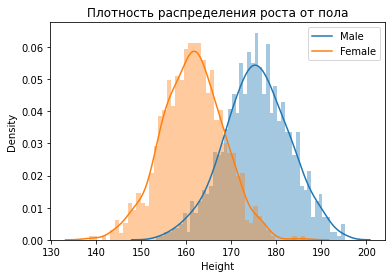

In [ ]:
sns.distplot(df_1['Height'], 50)
sns.distplot(df_2['Height'], 50)
plt.title('Плотность распределения роста от пола')
plt.legend(['Male', 'Female'])
plt.show()

Проверка Т-Тестом и Манна-Уитни

In [ ]:
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu

alpha = 0.05                          # Уровень значимости

In [ ]:
result = ttest_ind(df_1['Height'], df_2['Height'])
print('p-value: %.8f' % result.pvalue)

if (result.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-value: 0.00000000
Отвергаем нулевую гипотезу


In [ ]:
result = mannwhitneyu(df_1['Height'], df_2['Height'])
print('p-value: %.8f' % result.pvalue)

if (result.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-value: 0.00000000
Отвергаем нулевую гипотезу


Проверка Бутстрап

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm.auto import tqdm

alpha = 0.05                          # Уровень значимости

In [ ]:
def get_bootstrap(
    data_column_1,                    # Числовые значения первой выборки
    data_column_2,                    # Числовые значения второй выборки
    boot_it = 1000,                   # Количество бутстрэп-подвыборок
    statistic = np.mean,              # Интересующая нас статистика
    bootstrap_conf_level = 1-alpha    # Уровень значимости
):

    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):    # Извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len,
            replace = True            # Параметр возвращения
        ).values

        samples_2 = data_column_2.sample(
            boot_len,                 # Чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values

        boot_data.append(statistic(samples_1-samples_2))
    pd_boot_data = pd.DataFrame(boot_data)

    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])

    p_1 = norm.cdf(
        x = 0,
        loc = np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0,
        loc = -np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else:
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')

    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()

    print('p-value: %.8f' % p_value)

    return p_value

  0%|          | 0/1000 [00:00<?, ?it/s]

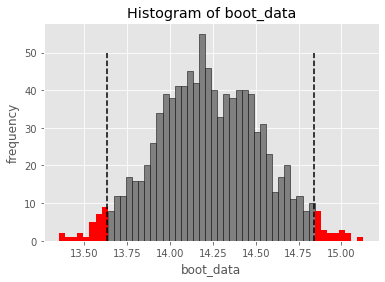

p-value: 0.00000000
Отвергаем нулевую гипотезу


In [ ]:
tmp_boot = get_bootstrap(
    df_1['Height'],                 # числовые значения первой выборки
    df_2['Height'],                 # числовые значения второй выборки
    boot_it = 1000,                 # количество бутстрэп-подвыборок
    statistic = np.mean,            # интересующая нас статистика
    bootstrap_conf_level = 1-alpha  # уровень значимости
)

if (tmp_boot < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')